# SeSiMe
### Sentence/Sequence Similarity Measure

### Mass spec side
Import MS data and create documents.

Here: Use NOT Crusemann data, but other dataset where smilea are known for all spectra.
### here: GNPS Dataset of 11134 spectra with smiles.

In [1]:
# data locations
# Windows 
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


## Documents

+ Peaks were removed using an exponential fit to the peak intensity distribution. 
+ Words were created using 2 decimals.

### Interesting to note: 
+ Not discriminating between **loss and peak has only very little influence on final result. Test was done with naming all peaks and losses by "mz_....". 

In [4]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.73', 'peak_79.02', 'peak_89.02', 'peak_89.04', 'peak_90.05', 'peak_95.05', 'peak_98.98', 'peak_105.04', 'peak_107.05', 'peak_117.03', 'peak_118.04', 'peak_134.67', 'peak_135.05', 'peak_135.28', 'peak_136.05', 'peak_137.00', 'peak_137.15', 'peak_145.03', 'peak_147.12', 'peak_160.09', 'peak_161.08', 'peak_162.59', 'peak_163.04', 'peak_163.08', 'peak_163.29', 'peak_164.04', 'peak_165.00', 'peak_165.40', 'peak_166.30', 'peak_167.15', 'peak_168.17', 'peak_172.58', 'peak_175.08', 'peak_181.06', 'peak_229.03', 'peak_237.01', 'peak_330.10', 'peak_330.14', 'loss_92.10', 'loss_100.08', 'loss_148.05', 'loss_154.04', 'loss_156.53', 'loss_160.95', 'loss_161.96', 'loss_162.81', 'loss_163.71', 'loss_164.11', 'loss_165.07', 'loss_165.82', 'loss_166.03', 'loss_166.07', 'loss_166.52', 'loss_168.04', 'loss_169.03', 'loss_182.00', 'loss_184.08', 'loss_191.96', 'loss_192.11', 'loss_193.07', 'loss_193.84', 'loss_194.07', 'loss_194.44', 'loss_211.07', 'loss_212.08', 'loss_222.06', 'loss_224.07', 'l

In [5]:
len(MS_documents)  # number of spectra = number of documents

9550

#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [6]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [7]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)

Preprocess documents...


In [8]:
print("Number of unique words: ", len(MS_measure.dictionary))

Number of unique words:  67455


## Word2Vec -based approach
### Compare different training parameters

+ Create Word2Vec based document centroid vectors based on models trained using different window sizes.

In [9]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [10]:
MS_measure.get_vectors_centroid(extra_weights = None, tfidf_weighted=True)
MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

  Calculated centroid vectors for  9550  of  9550  documents.  of  9550  documents.Calculated distances between  9550  documents.


This has calculated (cosine) distances between all spectra in an all-vs-all fashion.
The "num_hits" closest candidates for each spectrum are listed in two matrices.

One stores the distances, the other the respective IDs.

### Inspect closest candidates

In [13]:
MS_measure.list_similars_ctr_idx[1,:]

array([   1,  137,  304, 8923,  621, 1671,  559,   68, 1432, 1048, 6892,
        498, 1383, 6217,  985, 6907, 1889,   79,  813, 8649, 5881, 5811,
       9065,  162,  655])

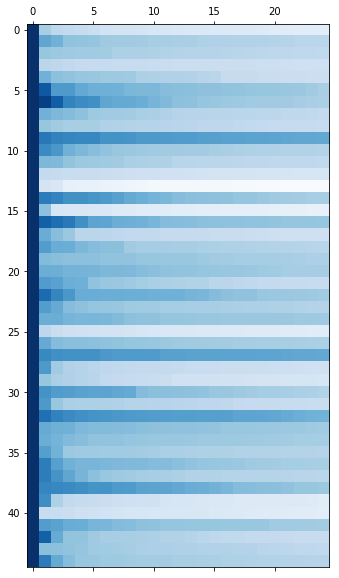

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(MS_measure.list_similars_ctr[:45,:25], cmap=plt.cm.Blues)

### Plot molecules from smiles to visually compare selected spectra

[110 527 304 244 394 145 137 877  30 953]
[1.      0.81059 0.77075 0.76905 0.73906 0.72549 0.71759 0.68504 0.67896
 0.6593 ]


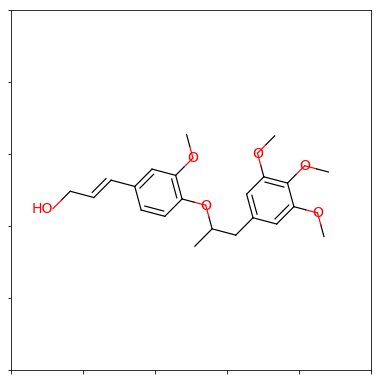

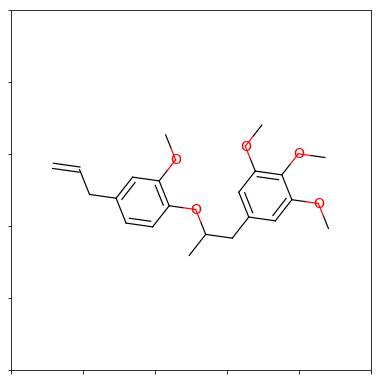

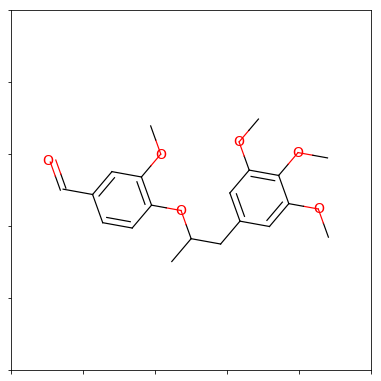

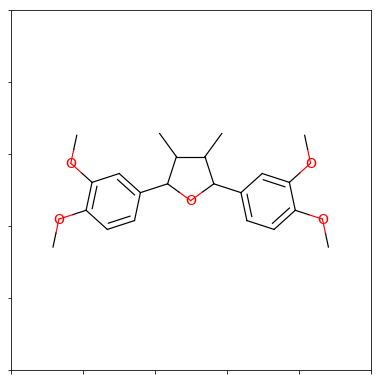

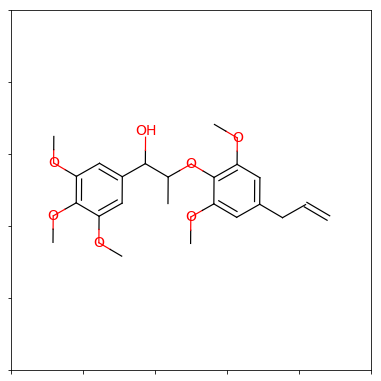

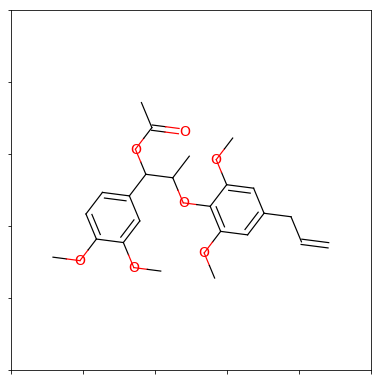

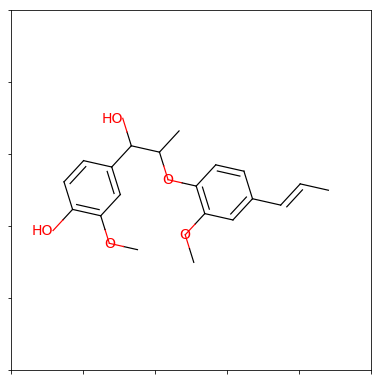

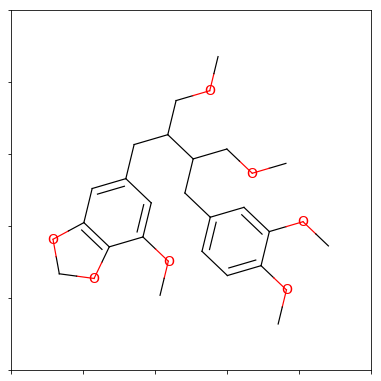

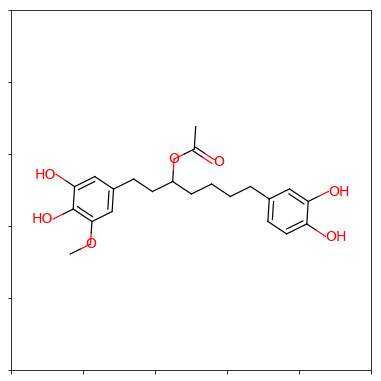

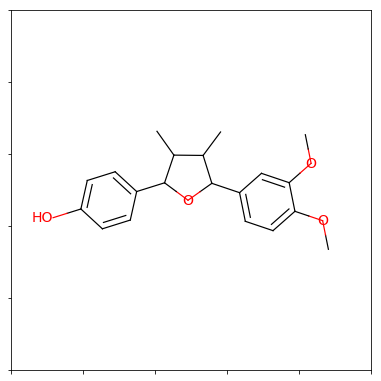

In [113]:
query_id = 110 #38 #7 #31#1110 #110
print(MS_measure.list_similars_ctr_idx[query_id, :10])
print(np.round(MS_measure.list_similars_ctr[query_id, :10],5))
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "centroid")

In [33]:
print("Spectrum ID: ", int(sub_spectra_metadata.iloc[204,1]))

Spectrum ID:  523


### Compare to Tanimoto scores and MolNet scores

1) Calculate molecular fingerprints (using smiles given for the spectra).

In [11]:
molecules, fingerprints, exclude_IDs = MS_functions.get_mol_similarity(spectra_dict, method = "daylight")#method = "morgan3")

Problem with molecule 7402
Problem with molecule 7452
Problem with molecule 7522
Problem with molecule 7612
Problem with molecule 13527
Problem with molecule 13771
Problem with molecule 14111
Problem with molecule 14429
Problem with molecule 14652
Problem with molecule 15085
Problem with molecule 15140
Problem with molecule 15175
Problem with molecule 15531
Problem with molecule 15810
Problem with molecule 15981
Problem with molecule 15997
Problem with molecule 16095
Problem with molecule 16129
Problem with molecule 16151
Problem with molecule 16160
Problem with molecule 16163
Problem with molecule 16706
Problem with molecule 16707
Problem with molecule 16708
Problem with molecule 16709
Problem with molecule 16710
Problem with molecule 16711
Problem with molecule 16885
Problem with molecule 16981
Problem with molecule 17119
Problem with molecule 35001
Problem with molecule 35006
Problem with molecule 35008
Problem with molecule 35009
Problem with molecule 35013
Problem with molecule 35

2) Calculate Tanimoto scores based on fingerprints.

In [214]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2.npy"
tanimoto_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


In [215]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
tanimoto_similarities_m3 = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

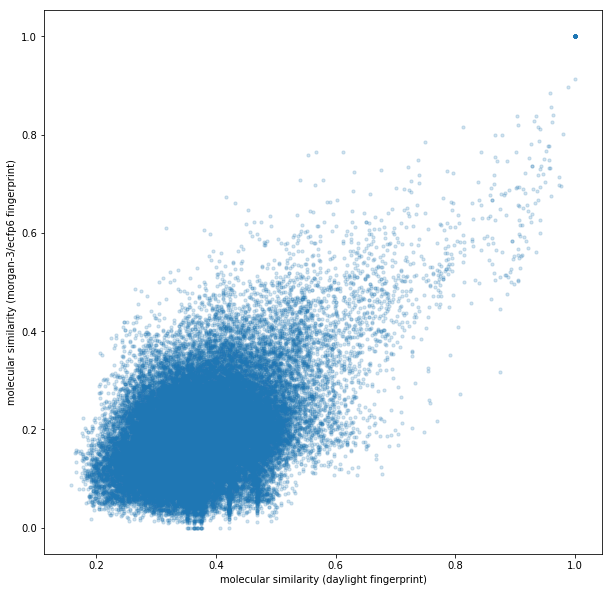

In [233]:
# measure agreement between daylight and morgan-3/ecfp6 fingerprint-based molecular similarity.
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:300,:300], tanimoto_similarities_m3[:300,:300], s=10, alpha=0.1)
plt.ylabel("molecular similarity (morgan-3/ecfp6 fingerprint)")
plt.xlabel("molecular similarity (daylight fingerprint)")

In [ ]:
from scipy import spatial
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

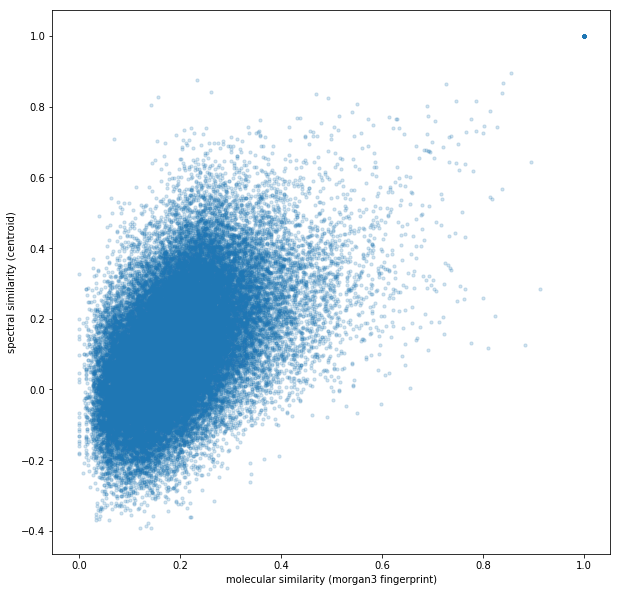

In [234]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:300,:300], M_sim_ctr[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

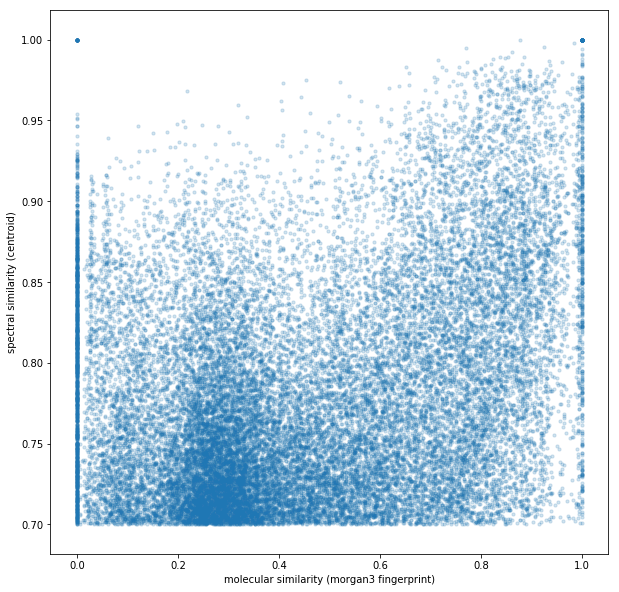

In [239]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.6)
select = np.where(M_sim_ctr > 0.7)
ax.scatter(tanimoto_similarities_m3[select], M_sim_ctr[select], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

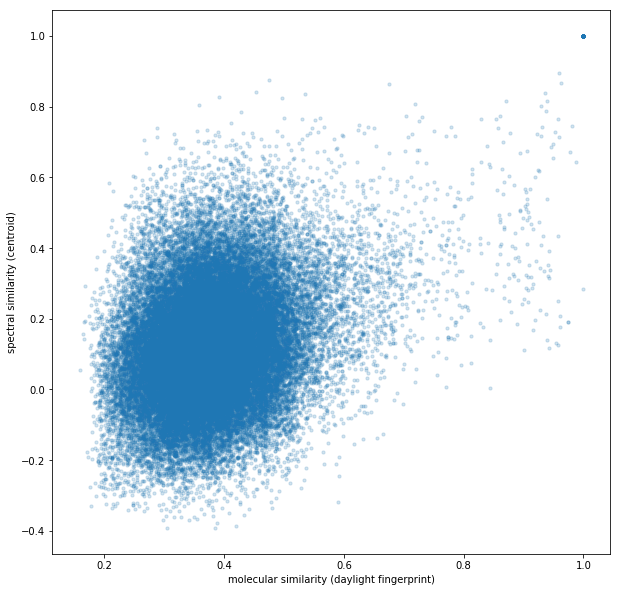

In [230]:
# measure agreement between molecular similarity (daylight fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:300,:300], M_sim_ctr[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (daylight fingerprint)")

Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

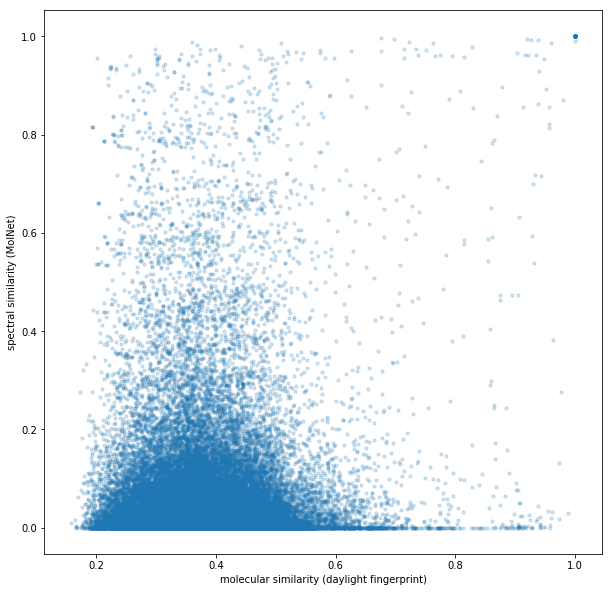

In [235]:
# measure agreement between molecular similarity (daylight fingerprint) and spectral similarity (MolNet)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:300,:300], molnet_sim[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (MolNet)")
plt.xlabel("molecular similarity (daylight fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

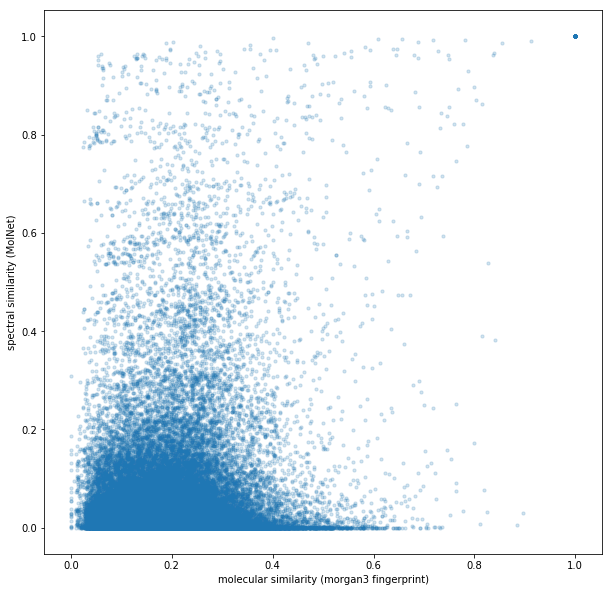

In [236]:
# measure agreement between molecular similarity (daylight fingerprint) and spectral similarity (MolNet)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:300,:300], molnet_sim[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (MolNet)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 + daylight fingerprint)')

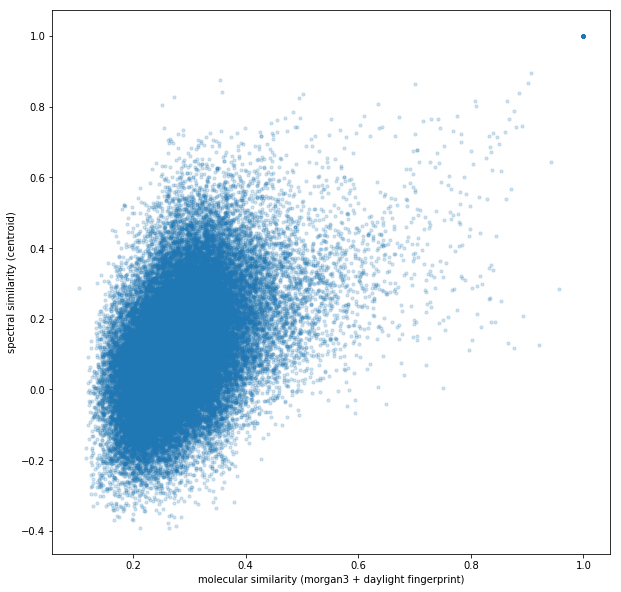

In [237]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(0.5*(tanimoto_similarities_m3[:300,:300] + tanimoto_similarities[:300,:300]), M_sim_ctr[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 + daylight fingerprint)")

3) Calculate the molecular networking score between spectra (**careful**: this is very slow!).

In [13]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol02_minmatch2_minintens_001.npy"
molnet_sim = MS_functions.molnet_matrix(spectra, 
                  tol = 0.2, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 2, 
                  min_intens = 0.01,
                  filename = filename)

MolNet similarity scores found and loaded.


[110 527 304 244 394 145 137 877  30 953]
[1.      0.81059 0.77075 0.76905 0.73906 0.72549 0.71759 0.68504 0.67896
 0.6593 ]


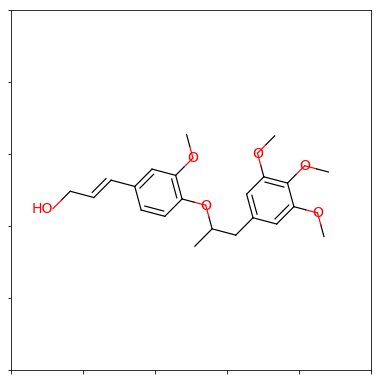

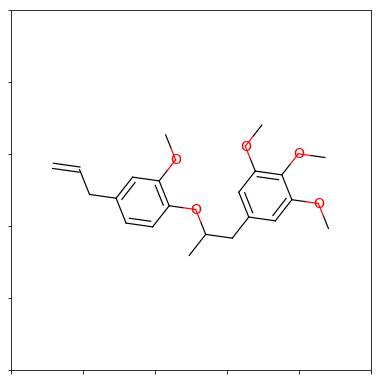

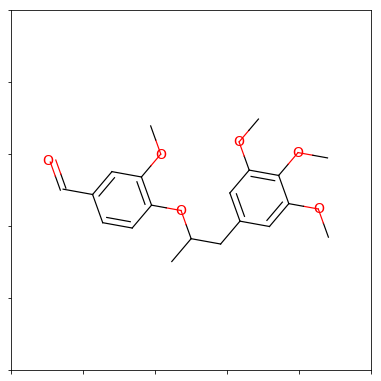

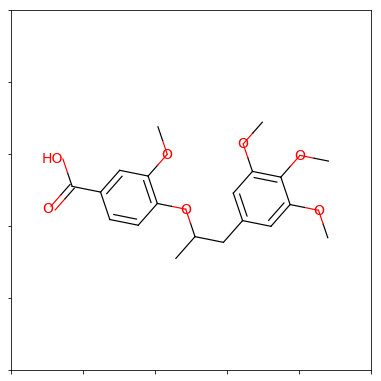

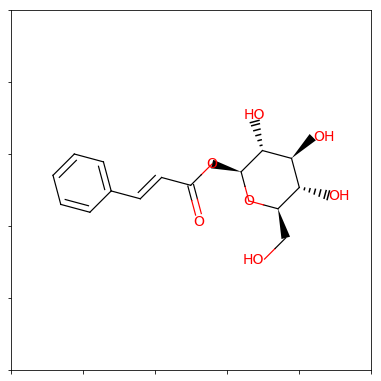

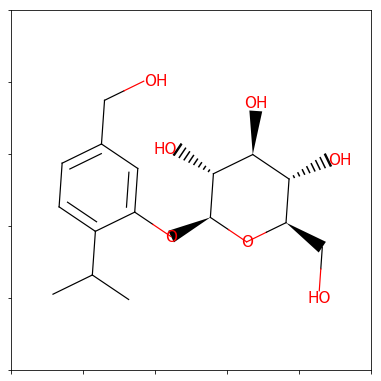

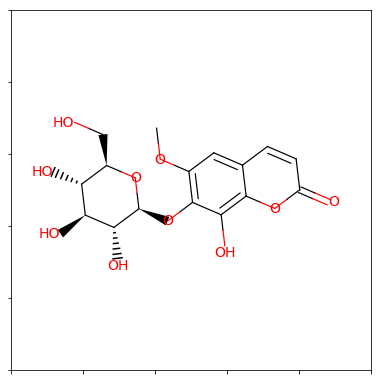

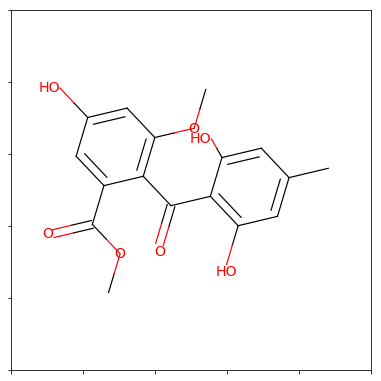

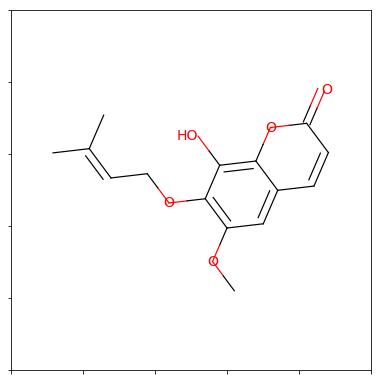

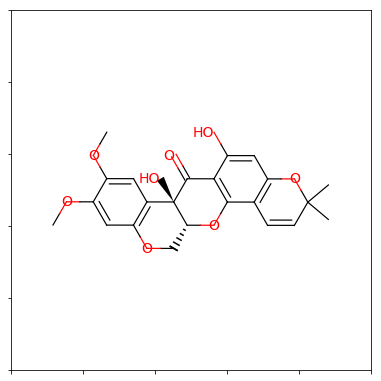

In [114]:
query_id = 110 #38 #7 #31#1110 #110
print(MS_measure.list_similars_ctr_idx[query_id, :10])
print(np.round(MS_measure.list_similars_ctr[query_id, :10],5))
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "molnet", 
                         plot_type = "single", molnet_sim = molnet_sim)

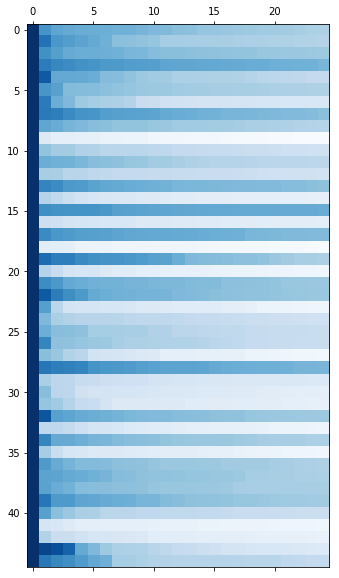

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(MS_measure.list_similars_ctr[200:245,:25], cmap=plt.cm.Blues)

### Searching for cases where molnet and word2vec-based measures disagree a lot

In [34]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim, spec_sim, spec_idx, reference_list = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "centroid", #"molnet",
                                                                   reference_list = None)


  Evaluate spectrum  9550  of  9550  spectra. Evaluate spectrum  2560  of  9550  spectra. spectra.  of  9550  spectra.

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


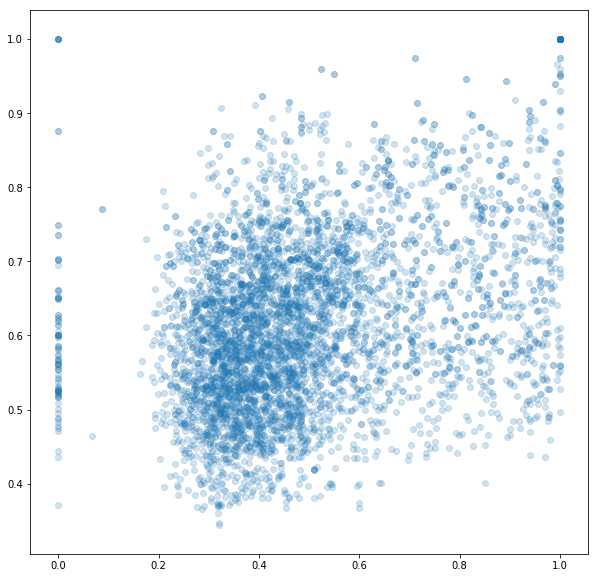

In [207]:
# try other plot type:
means = 1 - np.max(spec_sim[:,1:], axis=1)
spec_sim_norm = spec_sim.copy()
spec_sim_norm[:,1:] = spec_sim_norm[:,1:]/np.tile(means, (10,1)).T
#print(mol_sim_norm[:20])
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(mol_sim[5000:5500], spec_sim[5000:5500], alpha=0.2)

In [35]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim2, spec_sim2, spec_idx2, reference_list2 = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "molnet",
                                                                   molnet_sim = molnet_sim,
                                                                   reference_list = None)

  Evaluate spectrum  9550  of  9550  spectra.  spectra.

In [132]:
print(mol_sim2[7537,:])

[1.         0.33789062 0.3590998  0.38364462 0.48920141 0.33981576
 0.46884422 0.39537223 0.31882591 0.69821606 0.64139651]


In [42]:
print(mol_sim[:10,:6])

[[1.         0.63128492 0.69771529 0.41737033 0.38368247 0.60248447]
 [1.         0.46666667 0.52489627 0.35340314 0.62576687 0.25590551]
 [1.         0.41055046 0.38304094 0.37977805 0.37763975 0.37459634]
 [1.         0.52680965 0.39389068 0.4912854  0.5356711  0.58998647]
 [1.         0.41747573 0.41699605 0.5298185  0.31197559 0.64786585]
 [1.         1.         0.94252874 0.54278075 0.33773862 0.47790055]
 [1.         0.74025974 0.84153005 0.58282209 0.52968037 0.34431138]
 [1.         0.4363104  0.51150203 0.58038147 0.53125    0.53256705]
 [1.         0.34758621 0.4762419  0.26192541 0.34758621 0.33241758]
 [1.         0.47092288 0.38095238 0.57243402 0.89288136 0.35798203]]


In [54]:
find_weak_spots = np.mean(mol_sim[:,1:6], axis=1) - np.mean(mol_sim2[:,1:6], axis=1)
print(find_weak_spots[:100])

[-0.12516162 -0.04989713  0.04466554  0.1446598  -0.14245602  0.04805896
 -0.02251219  0.17283478  0.03260641  0.08626839  0.2112497  -0.03309646
 -0.0168027   0.19521627  0.1817734   0.01507989 -0.00633403 -0.0043783
  0.44105877  0.22185839  0.03051152  0.06061804  0.06125453  0.23518327
  0.15982101  0.0375413   0.11548851  0.06917888 -0.0791317  -0.06536655
  0.00569879 -0.03250049  0.07877606 -0.00730838 -0.02176424 -0.09313056
 -0.08591658  0.31697458  0.02938679 -0.03850404  0.11396682  0.0131589
  0.0320629   0.29576775  0.10697514  0.38562497  0.14909603  0.14489608
  0.3540928  -0.0721555  -0.0146622   0.12786296  0.26224533  0.07458927
  0.25769051  0.10032746  0.09823412  0.01317163 -0.12957505  0.06699022
  0.08684032  0.13422763  0.06043008 -0.16675503  0.09516314  0.02524512
 -0.04153986 -0.14254074  0.148589    0.23224239 -0.1107696  -0.00685018
  0.18176009  0.16401753  0.00250267  0.03870897 -0.34354883 -0.0175542
  0.08734978  0.01235837 -0.0090519   0.08189923  0.01

In [60]:
weakest = np.where(find_weak_spots > 0.5)[0]
print(weakest.shape)
weakest

(63,)


array([ 283,  481,  922, 1243, 1991, 2033, 2087, 2349, 2431, 2543, 2831,
       2875, 2885, 2890, 2911, 2941, 3362, 3411, 3478, 3496, 3500, 3502,
       3731, 3840, 3861, 3936, 3965, 3990, 4024, 4058, 4093, 4256, 4537,
       4539, 4687, 4698, 4703, 4756, 4858, 5062, 5104, 5118, 6350, 6546,
       6756, 6768, 6840, 6885, 6957, 6974, 6997, 7017, 7132, 7537, 7701,
       7747, 7824, 8100, 8265, 8324, 8377, 9324, 9388], dtype=int64)

Candidate IDs:  [7747. 7533. 7541. 7530. 7292. 7318. 7850. 7932. 7377. 7882. 7316.]
Similarity:  [1.         0.7124958  0.62163316 0.61491896 0.56949071 0.51627822
 0.47785705 0.47711849 0.44686355 0.43915227 0.4338522 ]
Tanimoto scores:  [1.         0.99684044 0.99684044 0.9890625  0.7689464  0.7689464
 0.51041667 0.5046729  0.49569892 0.81284404 0.47764228]


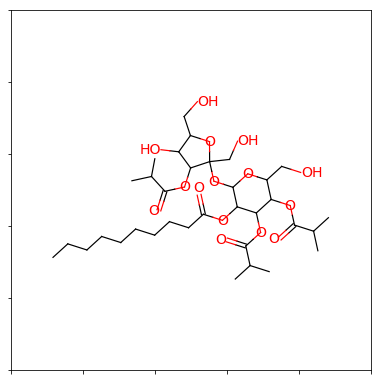

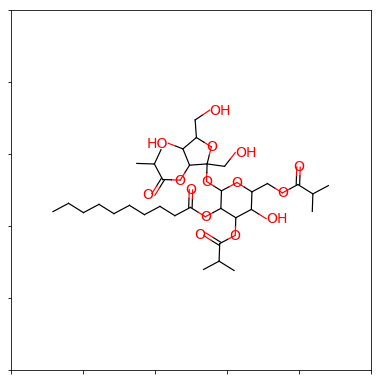

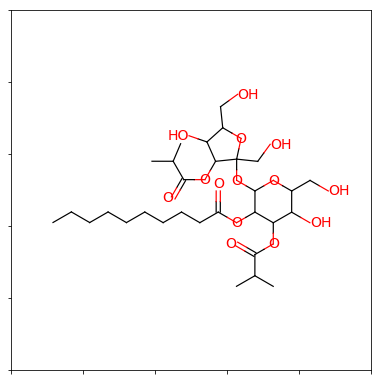

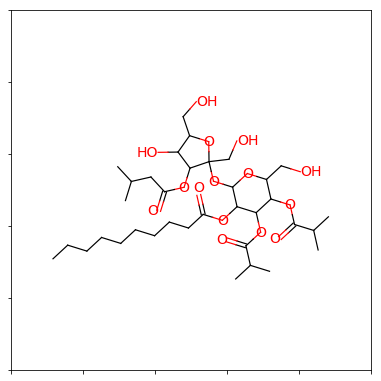

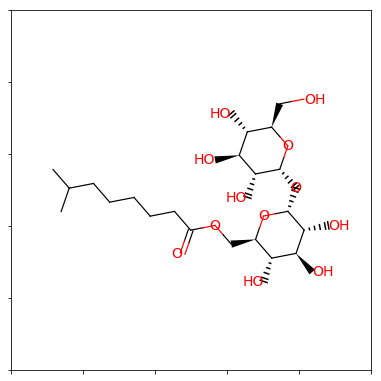

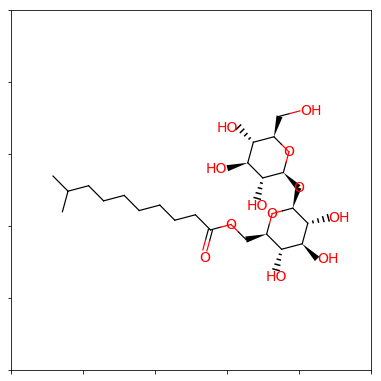

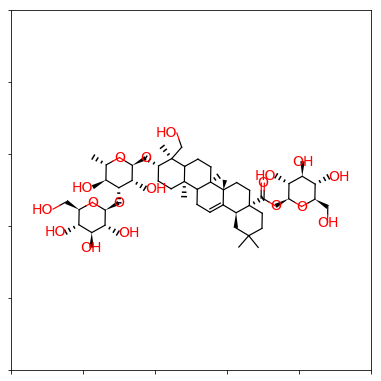

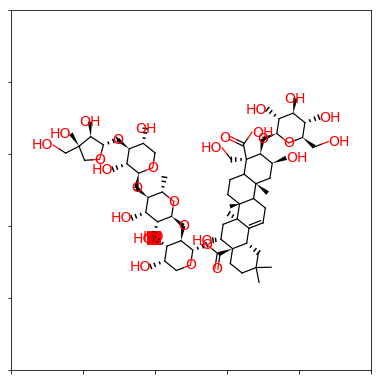

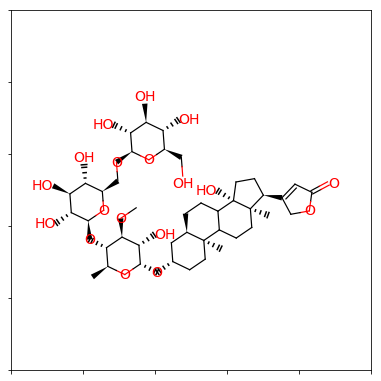

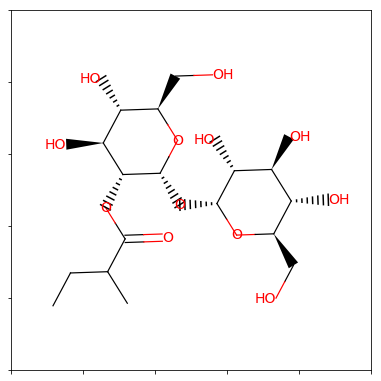

In [208]:
query_id = 7747 #7537 #6997 #6350 #5118 #1243 #283 #922 
print("Candidate IDs: ", spec_idx[query_id,:])
print("Similarity: ", spec_sim[query_id,:])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "centroid")
print("Tanimoto scores: ", mol_sim[query_id,:])

In [95]:
print("Spectrum ID: ", int(sub_spectra_metadata.iloc[1243,1]))

Spectrum ID:  3351


Candidate IDs:  [7747. 6852. 1819. 2886. 9386. 2026. 7474. 1706. 4244. 6932. 7128.]
Similarity:  [1.         0.61693827 0.60054163 0.59941293 0.59705989 0.5942849
 0.58474872 0.58214161 0.58184156 0.57851106 0.57780104]
Tanimoto scores:  [1.         0.44354839 0.30116811 0.20255183 0.32484076 0.29845168
 0.29551954 0.23649907 0.21304348 0.43982495 0.38444444]


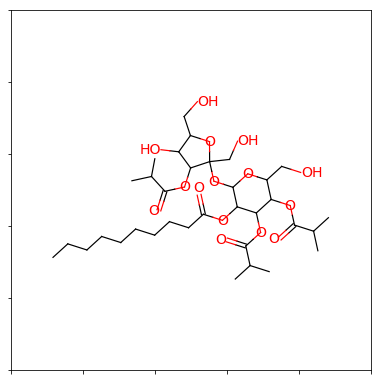

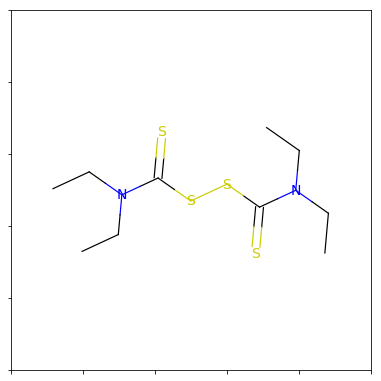

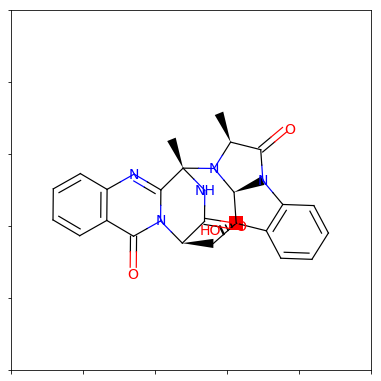

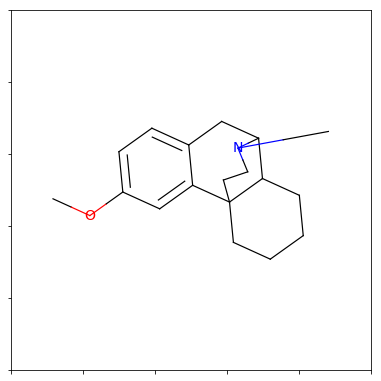

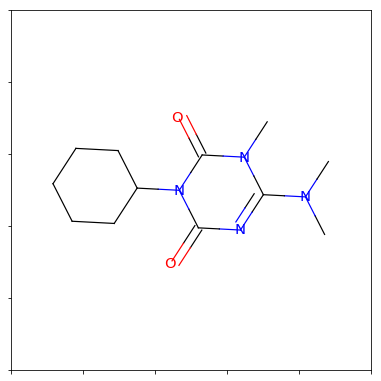

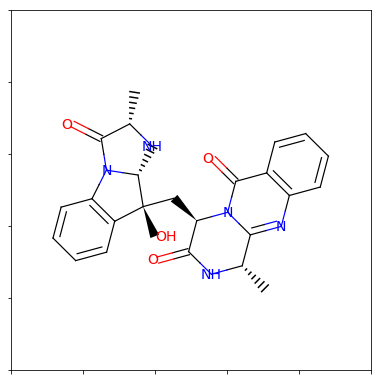

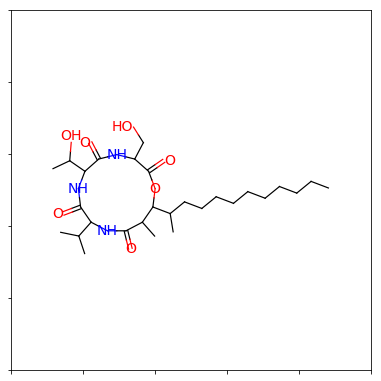

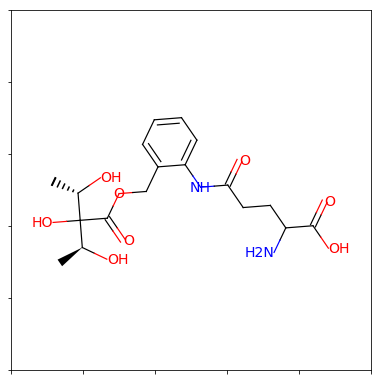

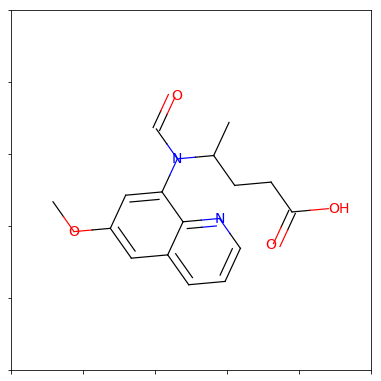

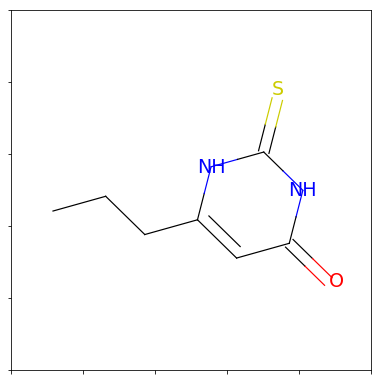

In [210]:
query_id = 7747#5311 #1243 #7537 #6997 #5118 #1243 #283 #922 
print("Candidate IDs: ", spec_idx2[query_id,:])
print("Similarity: ", spec_sim2[query_id,:])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "molnet", 
                         plot_type = "single", molnet_sim = molnet_sim)
print("Tanimoto scores: ", mol_sim2[query_id,:])

### Examples for Molnet outperforming w2v-centroid similarity measure

In [99]:
weakest_w2v = np.where(find_weak_spots < -0.4)[0]
print(weakest_w2v.shape)
weakest_w2v

(12,)


array([3235, 3275, 3576, 3606, 3617, 4132, 6095, 8294, 8490, 8609, 8935,
       9171], dtype=int64)

[9171 8288 9196 9072 9209 8223 8376 8191 8986 8985]
[1.      0.78283 0.76428 0.74346 0.73301 0.72579 0.71323 0.68129 0.67885
 0.66756]
Tanimoto scores:  [1.         0.36985507 0.42533937 0.41400911 0.47485714 0.48726655
 0.45336348 0.94779874 0.94069913 0.56945976 0.30830946]


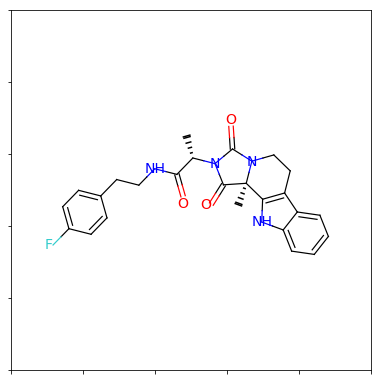

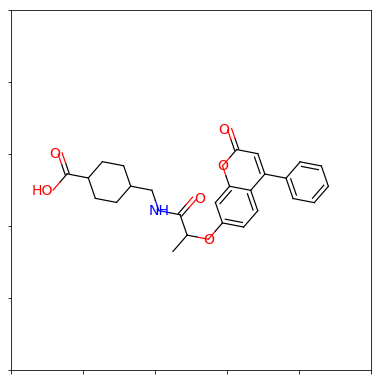

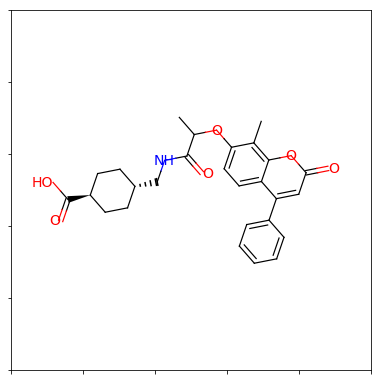

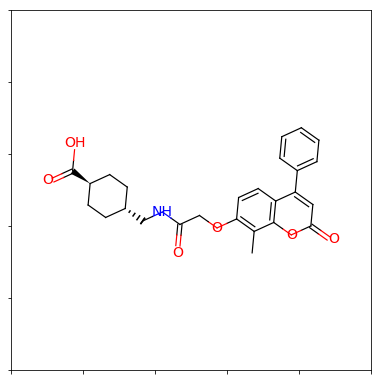

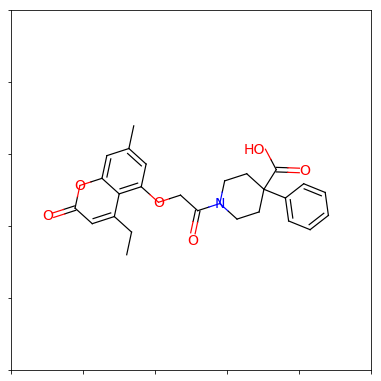

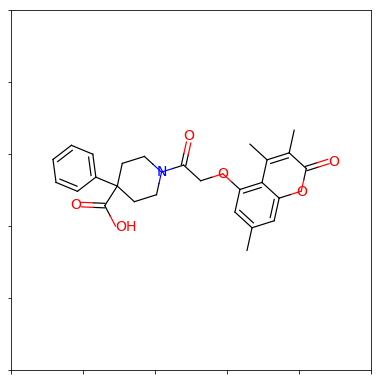

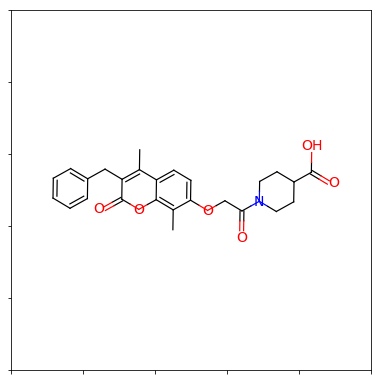

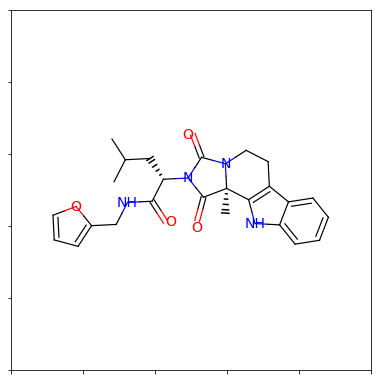

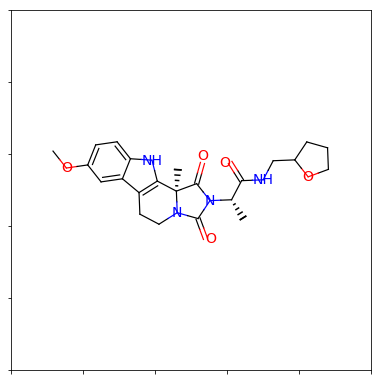

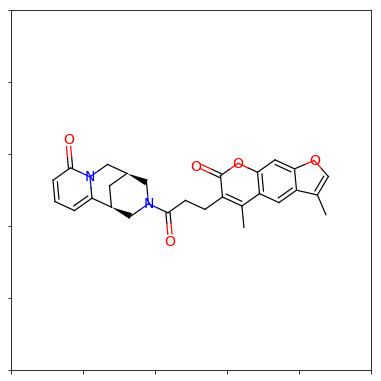

In [155]:
query_id = 9171#8294 #3576 #6095 #3235 #283 #922 
print(MS_measure.list_similars_ctr_idx[query_id, :10])
print(np.round(MS_measure.list_similars_ctr[query_id, :10],5))
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "centroid")
print("Tanimoto scores: ", mol_sim[query_id,:])

[8609 8562 8569  859 9051  977 8315 8895 9150 8093]
[1.      0.55895 0.55492 0.55226 0.54936 0.54859 0.54324 0.54163 0.53399
 0.52477]
Tanimoto scores:  [1.         0.8625171  0.86152797 0.85733604 0.86075085 0.83574244
 0.38656614 0.3775     0.39585947 0.82091798 0.40958738]


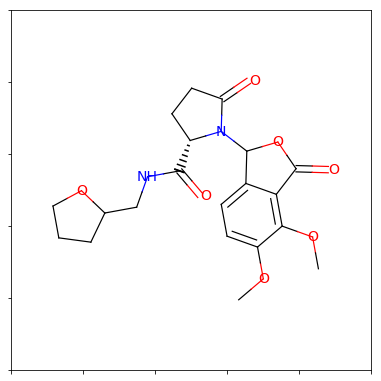

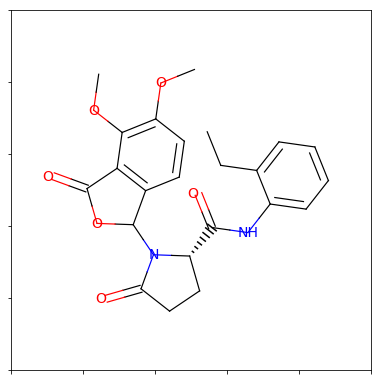

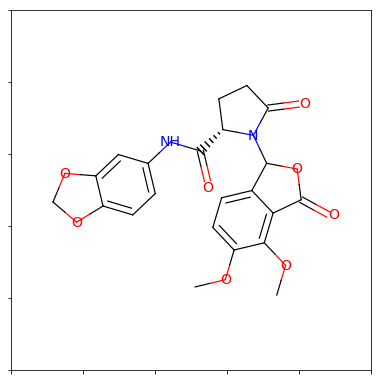

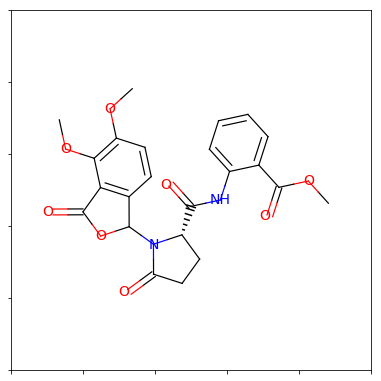

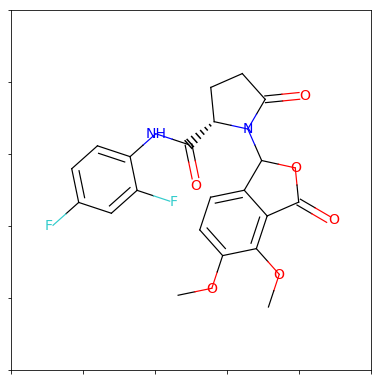

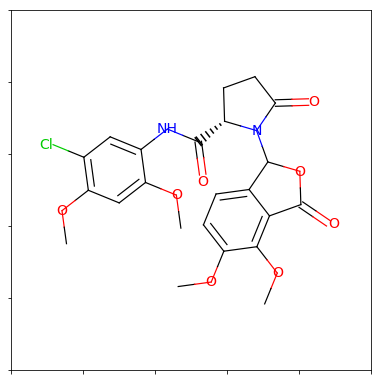

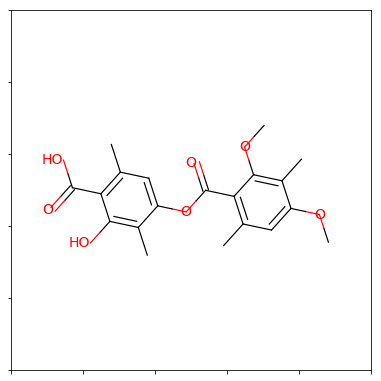

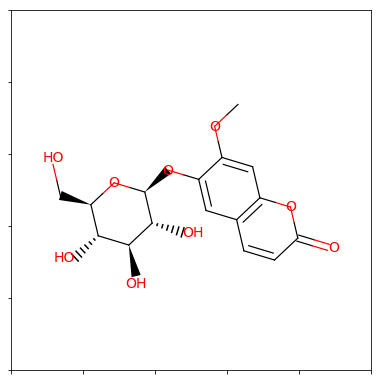

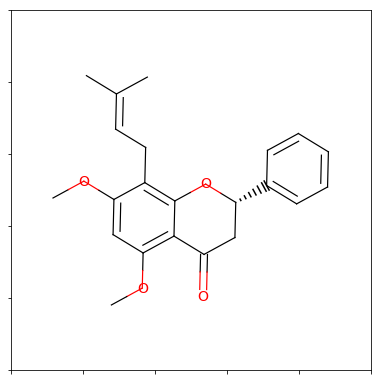

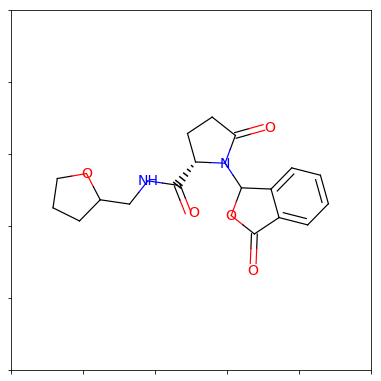

In [148]:
query_id = 8609 #4132 #3576 #6095 #3235 #283 #922 
print(MS_measure.list_similars_ctr_idx[query_id, :10])
print(np.round(MS_measure.list_similars_ctr[query_id, :10],5))
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, similarity_method = "molnet", 
                         plot_type = "single", molnet_sim = molnet_sim)
print("Tanimoto scores: ", mol_sim2[query_id,:])

### One of the reasons sometimes is: low peak resolution! 
+ e.g. for spectrum 4132 (spectrum ID: 27926)

In [90]:
print(MS_documents[4132]) 
print()
print(MS_documents_intensity[4132])

['peak_40.00', 'peak_41.00', 'peak_43.00', 'peak_55.00', 'peak_67.00', 'peak_68.00', 'peak_69.00', 'peak_77.00', 'peak_79.00', 'peak_83.00', 'peak_90.00', 'peak_97.00', 'peak_103.00', 'peak_117.00', 'peak_118.00', 'peak_132.00', 'peak_133.00', 'peak_150.00', 'peak_151.00', 'peak_152.00', 'peak_153.00', 'peak_154.00', 'peak_161.00', 'loss_125.27', 'loss_132.27', 'loss_133.27', 'loss_134.27', 'loss_135.27', 'loss_136.27', 'loss_153.27', 'loss_154.27', 'loss_168.27', 'loss_169.27', 'loss_183.27', 'loss_189.27', 'loss_196.27', 'loss_203.27', 'loss_207.27', 'loss_209.27', 'loss_217.27', 'loss_218.27', 'loss_219.27', 'loss_231.27', 'loss_243.27', 'loss_245.27', 'loss_246.27']

[46, 206, 38, 36, 143, 81, 298, 92, 37, 30, 108, 30, 87, 30, 109, 78, 154, 66, 101, 223, 999, 46, 66, 66, 46, 999, 223, 101, 66, 154, 78, 109, 30, 87, 30, 108, 30, 37, 92, 298, 81, 143, 36, 38, 206, 46]


In [97]:
print(MS_documents[3624]) 
print()
print(MS_documents_intensity[3624])

['peak_54.00', 'peak_55.00', 'peak_56.00', 'peak_57.00', 'peak_59.00', 'peak_66.00', 'peak_67.00', 'peak_68.00', 'peak_69.00', 'peak_70.00', 'peak_71.00', 'peak_72.00', 'peak_74.00', 'peak_76.00', 'peak_78.00', 'peak_79.00', 'peak_80.00', 'peak_81.00', 'peak_82.00', 'peak_83.00', 'peak_85.00', 'peak_88.00', 'peak_89.00', 'peak_92.00', 'peak_93.00', 'peak_94.00', 'peak_98.00', 'peak_105.00', 'peak_126.00', 'peak_136.00', 'peak_137.00', 'peak_143.00', 'peak_144.00', 'peak_145.00', 'peak_188.00', 'peak_192.00', 'peak_208.00', 'peak_252.00', 'peak_271.00', 'loss_41.30', 'loss_60.30', 'loss_104.30', 'loss_120.30', 'loss_124.30', 'loss_167.30', 'loss_168.30', 'loss_169.30', 'loss_175.30', 'loss_176.30', 'loss_186.30', 'loss_207.30', 'loss_214.30', 'loss_218.30', 'loss_219.30', 'loss_220.30', 'loss_223.30', 'loss_224.30', 'loss_227.30', 'loss_229.30', 'loss_230.30', 'loss_231.30', 'loss_232.30', 'loss_233.30', 'loss_234.30', 'loss_236.30', 'loss_238.30', 'loss_240.30', 'loss_241.30', 'loss_24

In [103]:
#8316 8399
print(MS_documents[8316]) 
print()
print(MS_documents_intensity[8316])

['peak_98.06', 'peak_115.05', 'peak_115.09', 'peak_117.07', 'peak_120.08', 'peak_124.07', 'peak_130.06', 'peak_143.07', 'peak_144.08', 'peak_145.08', 'peak_156.08', 'peak_168.08', 'peak_169.08', 'peak_170.06', 'peak_170.09', 'peak_171.09', 'peak_183.09', 'peak_184.07', 'peak_185.11', 'peak_186.11', 'peak_187.11', 'peak_195.09', 'peak_196.07', 'peak_198.13', 'peak_210.10', 'peak_211.09', 'peak_212.09', 'peak_213.10', 'peak_214.11', 'peak_239.08', 'peak_239.15', 'peak_240.08', 'peak_240.11', 'peak_241.08', 'peak_241.12', 'peak_256.11', 'peak_257.11', 'peak_267.15', 'peak_282.16', 'peak_283.16', 'peak_284.16', 'peak_292.14', 'peak_293.14', 'peak_295.13', 'peak_310.15', 'peak_311.16', 'peak_312.16', 'loss_190.06', 'loss_191.06', 'loss_192.07', 'loss_207.09', 'loss_209.08', 'loss_210.08', 'loss_218.06', 'loss_219.06', 'loss_220.06', 'loss_235.07', 'loss_245.11', 'loss_246.11', 'loss_261.11', 'loss_261.14', 'loss_262.11', 'loss_262.15', 'loss_263.07', 'loss_263.14', 'loss_288.12', 'loss_289.

In [136]:
test_set = set(MS_documents[8609])
print(test_set)
#test_set.update(MS_documents[8294])
#len(test_set), len(MS_documents[8316]), len(MS_documents[8294])

{'loss_308.01', 'peak_196.24', 'loss_235.92', 'peak_170.21', 'peak_156.19', 'peak_214.25', 'loss_278.01', 'peak_140.18', 'peak_240.25', 'loss_252.97', 'loss_264.97', 'peak_212.27', 'loss_291.00', 'loss_164.87', 'loss_276.98', 'peak_187.24', 'peak_213.25', 'peak_211.27', 'peak_282.32', 'loss_163.87', 'peak_198.25', 'peak_211.23', 'peak_196.21', 'peak_168.20', 'loss_191.88', 'peak_254.30', 'loss_331.04', 'peak_169.20', 'peak_154.17', 'loss_236.96', 'loss_193.89', 'loss_305.02', 'loss_263.97', 'loss_294.02', 'peak_143.17', 'peak_194.23', 'loss_210.93', 'loss_137.86', 'peak_284.33', 'loss_249.94', 'loss_233.94', 'peak_254.83', 'loss_193.37', 'peak_239.28', 'loss_235.96', 'peak_170.18', 'peak_183.22', 'peak_142.16', 'loss_192.89', 'loss_251.96', 'loss_193.94', 'peak_117.15', 'loss_277.98', 'peak_257.31', 'peak_167.19', 'loss_207.94', 'loss_209.90', 'peak_255.31', 'loss_279.00', 'loss_262.96', 'loss_208.95', 'loss_236.92', 'loss_304.01', 'loss_345.06', 'peak_145.18', 'loss_253.96', 'peak_310

In [156]:
print("Spectrum ID: ", int(sub_spectra_metadata.iloc[9171,1]))

Spectrum ID:  89010


In [157]:
print(MS_documents[9171]) 
print()
print(MS_documents_intensity[9171])

['peak_103.09', 'peak_105.08', 'peak_116.86', 'peak_123.10', 'peak_124.11', 'peak_144.13', 'peak_145.13', 'peak_167.13', 'peak_168.14', 'peak_169.14', 'peak_169.35', 'peak_170.11', 'peak_170.15', 'peak_171.15', 'peak_183.15', 'peak_184.16', 'peak_185.17', 'peak_186.18', 'peak_196.14', 'peak_196.16', 'peak_199.19', 'peak_211.16', 'peak_211.20', 'peak_212.16', 'peak_212.21', 'peak_213.18', 'peak_214.18', 'peak_222.17', 'peak_237.19', 'peak_238.21', 'peak_239.16', 'peak_239.21', 'peak_240.17', 'peak_241.93', 'peak_253.51', 'peak_254.09', 'peak_254.22', 'peak_255.22', 'peak_256.22', 'peak_282.22', 'peak_283.22', 'peak_284.23', 'peak_310.22', 'loss_137.97', 'loss_163.96', 'loss_164.97', 'loss_165.97', 'loss_191.97', 'loss_192.97', 'loss_193.97', 'loss_194.10', 'loss_194.68', 'loss_206.26', 'loss_208.02', 'loss_208.98', 'loss_209.03', 'loss_209.98', 'loss_211.00', 'loss_226.02', 'loss_234.01', 'loss_235.02', 'loss_235.99', 'loss_236.03', 'loss_237.00', 'loss_237.03', 'loss_249.00', 'loss_252

## Further tests with other measure (lsi, pca etc.)

Compare to word2vec and also test combinations!

### Try different similarity measuring methods...

#### A) LSI
LSI topic modeling....

In [240]:
file_model_lsi =  PATH_SAVE_MODEL + 'model_lsi_MS_uniquesmiles_topic300_iter20_loss500_minpeak10_dec2.model' 
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=300, num_iter=20, use_stored_model=True)

Stored LSI model not found!
Calculating new LSI model...


In [241]:
MS_measure.get_lsi_similarity(num_hits=25)

In [243]:
import gensim
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lsi[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim_lsi = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim_lsi[:,i] = similarities

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

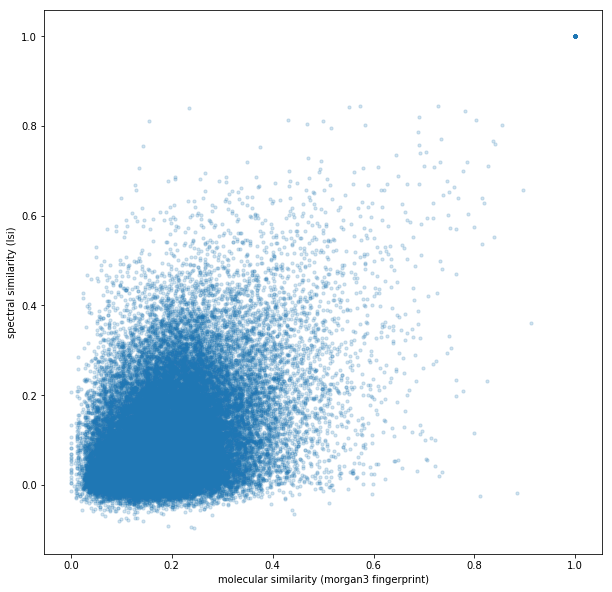

In [248]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:300,:300], M_sim_lsi[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

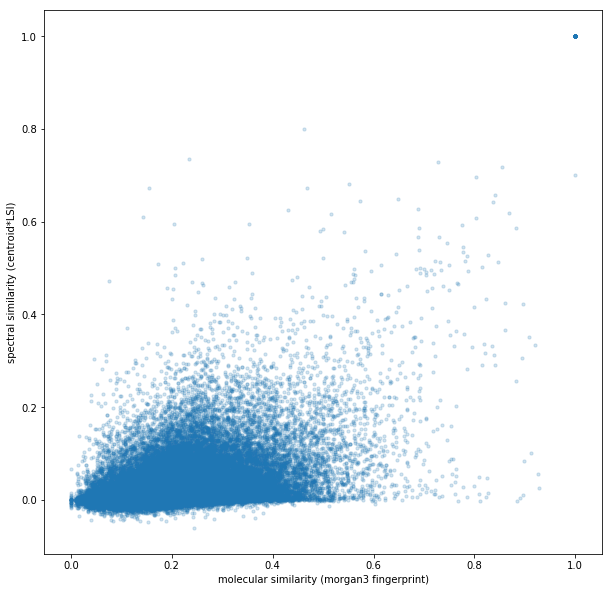

In [267]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:400,:400], M_sim_ctr[:400,:400]*M_sim_lsi[:400,:400], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid*LSI)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

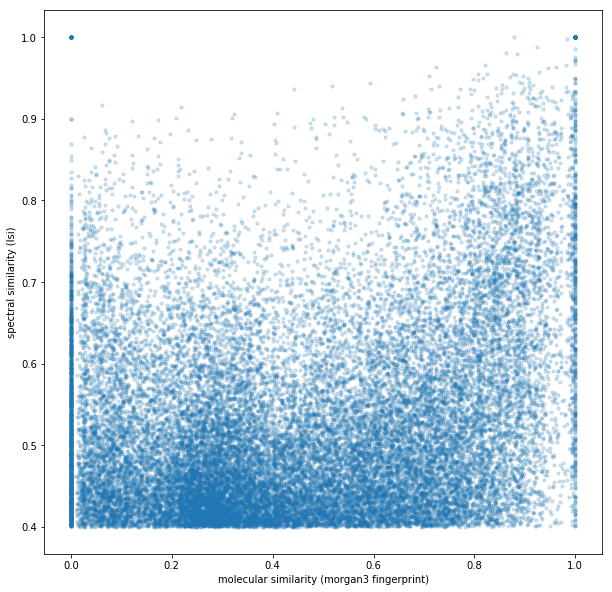

In [269]:
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.7)
select = np.where(M_sim_lsi*M_sim_ctr > 0.4)
ax.scatter(tanimoto_similarities_m3[select], M_sim_lsi[select]*M_sim_ctr[select], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

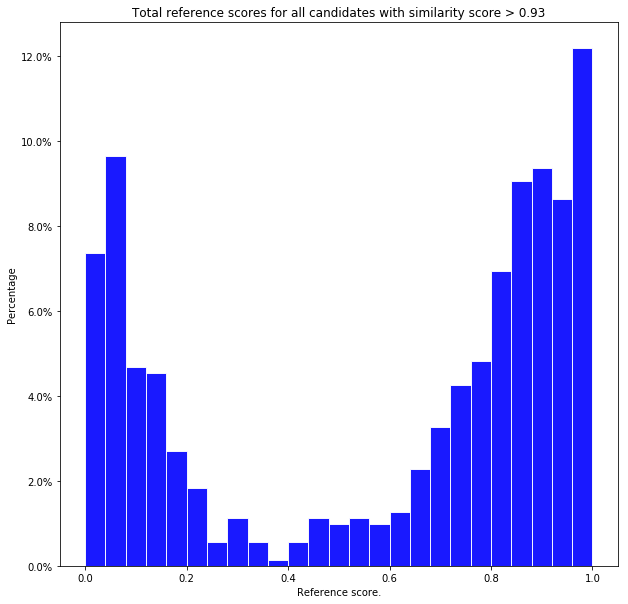

In [262]:
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities_m3, 0.93, 
                                            num_bins=25, exclude_IDs = exclude)

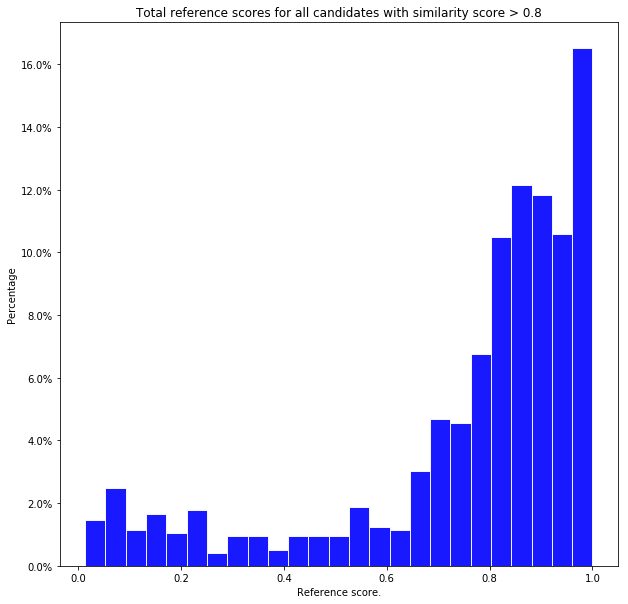

In [264]:

n, bins = MS_functions.similarity_histogram(M_sim_ctr*M_sim_lsi, tanimoto_similarities_m3, 0.8, 
                                            num_bins=25, exclude_IDs = exclude)

In [265]:
np.sum(n[12:])

0.8577362409138103

In [261]:
#np.sum(M_sim_ctr*M_sim_lsi >0.8)
np.sum(M_sim_lsi >0.93)

10970

#### F) Autoencoder
Will train a deep autoencoder to generate 100 dimensional (or = encoding_dim) vectors representing each document. 

In [81]:
file_model_ae = PATH_SAVE_DATA + 'model_autoencoder_MS_uniquesmiles2.h5'
file_model_encoder = PATH_SAVE_DATA + 'model_encoder_MS_uniquesmiles2.h5'
MS_measure.build_autoencoder(file_model_ae, file_model_encoder, 
                             epochs = 8, batch_size = 1024, encoding_dim = 300,
                            layer_factors = (1, 1, 1))

No stored model found!
Creating new autoencoder model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               16956300  
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_15 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_16 (Dense)   

In [82]:
MS_measure.get_autoencoder_distances(num_hits=25, method='cosine')

[0.00000000e+00 1.08270215e-07 1.39865922e-07 2.50640856e-07
 2.71289795e-07 2.73772700e-07 2.87246752e-07 3.04670363e-07
 3.12957884e-07 3.16611003e-07]


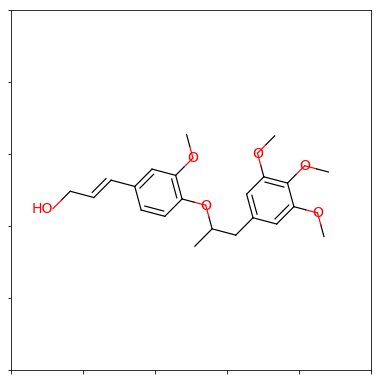

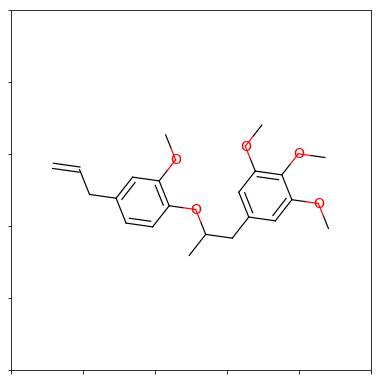

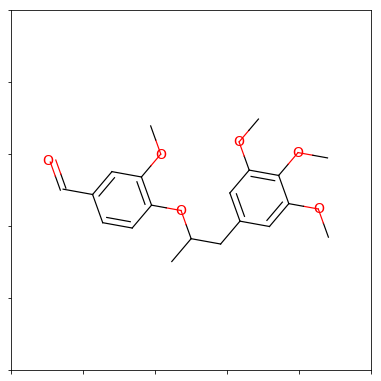

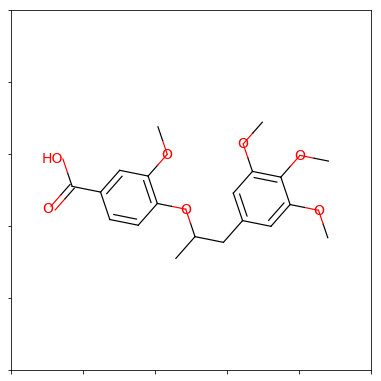

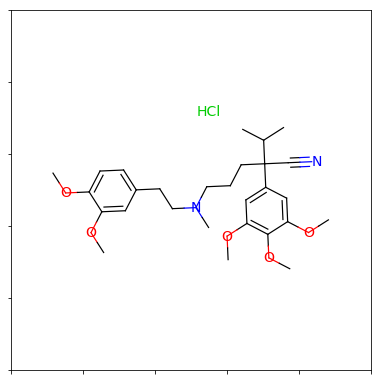

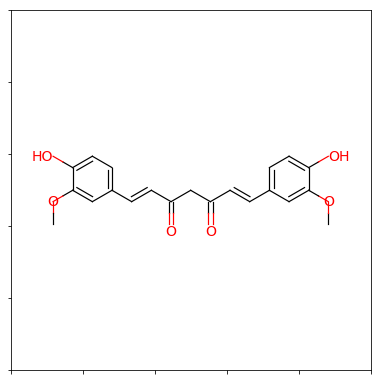

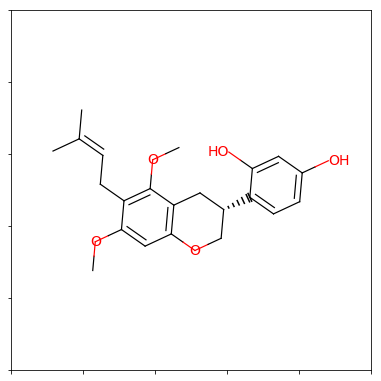

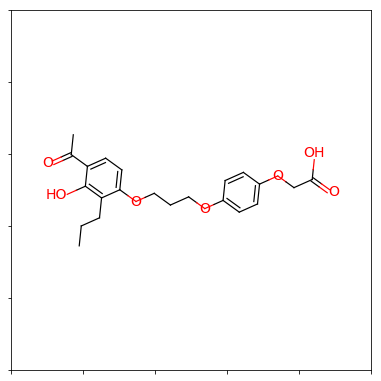

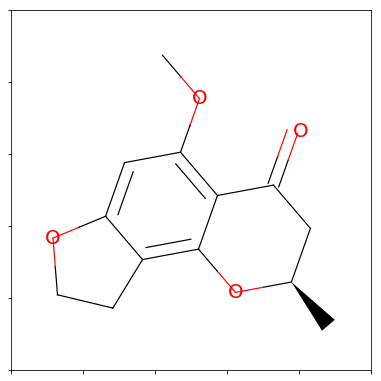

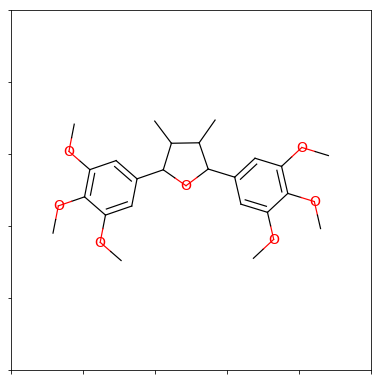

In [83]:
query_id = 110
print(MS_measure.Cdistances_ae[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict1, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "autoencoder")

#### B) PCA
Will calulate 300 dimensional representations of each document using PCA.

In [69]:
MS_measure.get_vectors_pca(300)

In [70]:
MS_measure.get_pca_distances(num_hits=25, method='cosine')

[1.11022302e-16 1.34778035e-01 1.87372251e-01 2.35544399e-01
 3.17293470e-01 3.22967926e-01 3.68596064e-01 4.07776146e-01
 4.14090705e-01 4.18957916e-01]


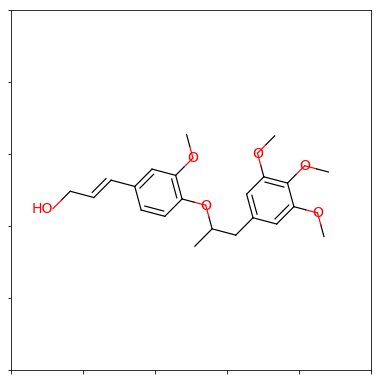

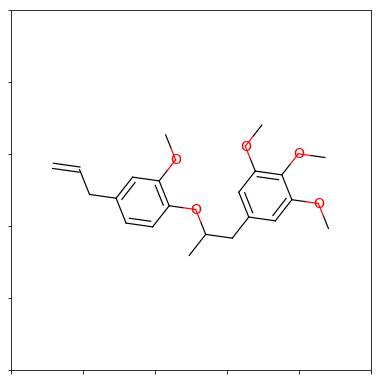

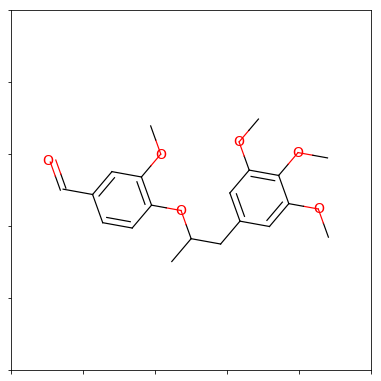

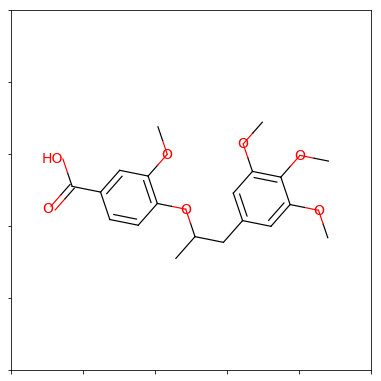

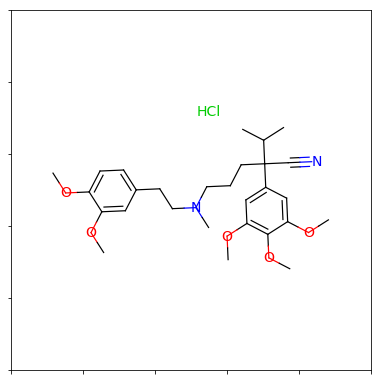

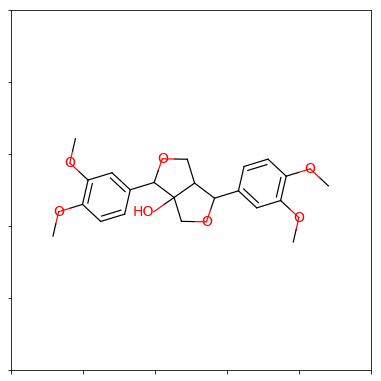

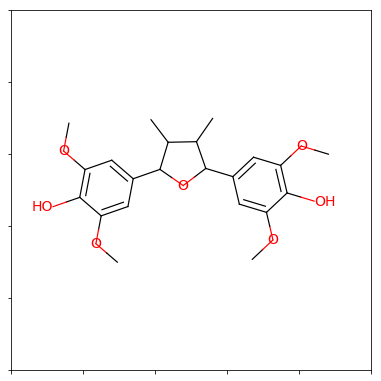

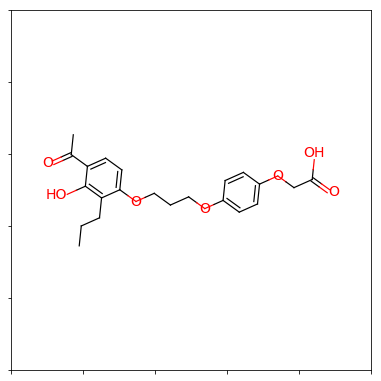

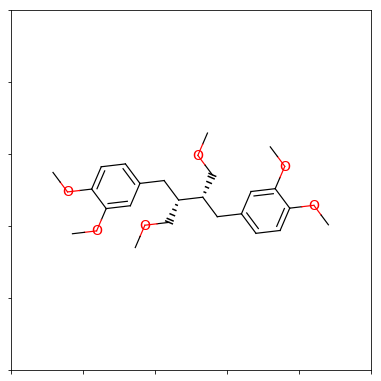

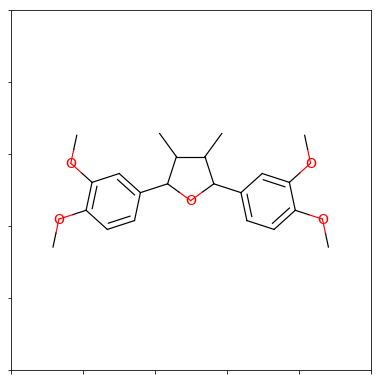

In [84]:
query_id = 110
print(MS_measure.Cdistances_pca[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict1, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "pca")